<a href="_index.ipynb">&larr; SPS </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>
# Einführung Spektralschätzung

 * Demonstriere Short-Term Fourier Transform mit verschiedenen Signalen
 
 * STFT wird dargestellt mit Spectrogram und Wasserfall-Diagramm

 * Testen Sie den Einfluss verschiedener Fensterlängen und Fenstertypen


In [6]:
import numpy as np
from numpy import (pi, log10, exp, sqrt, sin, cos, tan, angle, arange,
                    linspace, array, zeros, ones)
from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
import scipy.signal as sig

# %matplotlib widget
# "%matplotlib widget" enables interactive plot widgets but requires the modules ipympl and ipywidgets.
# If needed, install them from a console with 'pip install ipympl ipywidgets'
# or, from within this jupyter notebook with '%pip install ipympl ipywidgets'
import matplotlib.pyplot as plt
from matplotlib.pyplot import (figure, plot, stem, grid, xlabel, ylabel,
    subplot, title, clf, xlim, ylim)
figsize = {"figsize": (12,5)}

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

In [7]:
fs = 100e3 # Abtastfrequenz
NFFT = 1000 # FFT Punkte

fsig = 10000 # Signalfrequenz
Asig = 1 # Signalamplitude
fsig2 = 8376
Asig2 = 1
fmod = 0.5  # Modulationsfrequenz
Amod = 5000 # Modulation gain in Hz / V
tmax = 5 # Simulationzeit in s

dbmin = -120; dbmax = 0 # Limits für log. Darstellung



n = arange(NFFT/2 + 1)
t_label = r'$t$ in s $\rightarrow$'
f_label = r'$f$ in Hz $\rightarrow$'
H_label = r'$|H(e^{j \Omega}, t)|$ in dB $\rightarrow$'

t = arange(0, tmax, 1/fs)
x = Asig*sig.chirp(t, 100, tmax, 1e5) # Chirp-Impuls
#x = Asig*(sin(t* 2* pi * fsig) + 1) # Reiner Sinus
#x = Asig*sin(t* 2* pi * fsig + Amod *sin(t* 2* pi * fmod)) # FM-Signal
#x = Asig *sin(t* 2* pi * (fsig + Amod * np.sign(sin(t * 2 * pi * fmod)))) # FSK-Signal
x += Asig2 * sin(t* 2* pi * fsig2) # Zusätzlicher Sinuston
x += 0.001* np.random.randn(len(t))
#x = A*np.sign(x) # Rechteckfunktion

Im Folgenden wird eine Fensterfunktion zur Berechnung der FFT definiert.

In [8]:
win = sig.windows.kaiser(NFFT,12, sym = False) # needs NFFT and shape parameter beta 
win = sig.windows.hann(NFFT, sym = False)
win = sig.windows.blackman(NFFT, sym = False)
#win = sig.windows.boxcar(NFFT) # rectangular window

# Calculate Equivalent Noise Bandwidth + Coherent Gain
ENBW = len(win)*np.sum(win**2)/ np.sum(abs(win))**2
CGain = np.sum(win)/len(win)

## FFT
Man kann das Spektrum des gesamten Signals mit einer FFT darstellen, auch wenn das bei längeren Signalen ziemlich rechenintensiv werden kann. Wenn das Signal sich über der Zeit ändert, ist der Informationsgehalt des Spektrums aber nicht besonders groß, es gbibt dann quasi das "durchschnittliche Spektrum" an.

## Spektrogramm
Ein Spektrogramm stellt das Betragsspektrum $|H_{xx}(f, t)|$ in Abhängigkeit von Zeit und Frequenz dar, der Betrag wird dabei über die Farbe kodiert. Bei einem Spektrogramm wird das Zeitsignal durch eine Abfolge FFTs analysiert mit jeweils `NFFT` Punkten. Meistens lässt man die Teilfenster überlappen, damit an den Übergängen keine Information verloren geht. 

Im folgenden wird das Spektrogramm des gesamten Zeitsignals sowie das "FFT - Scheibchen" zum Zeitpunkt $t_1 = 1.2$s.

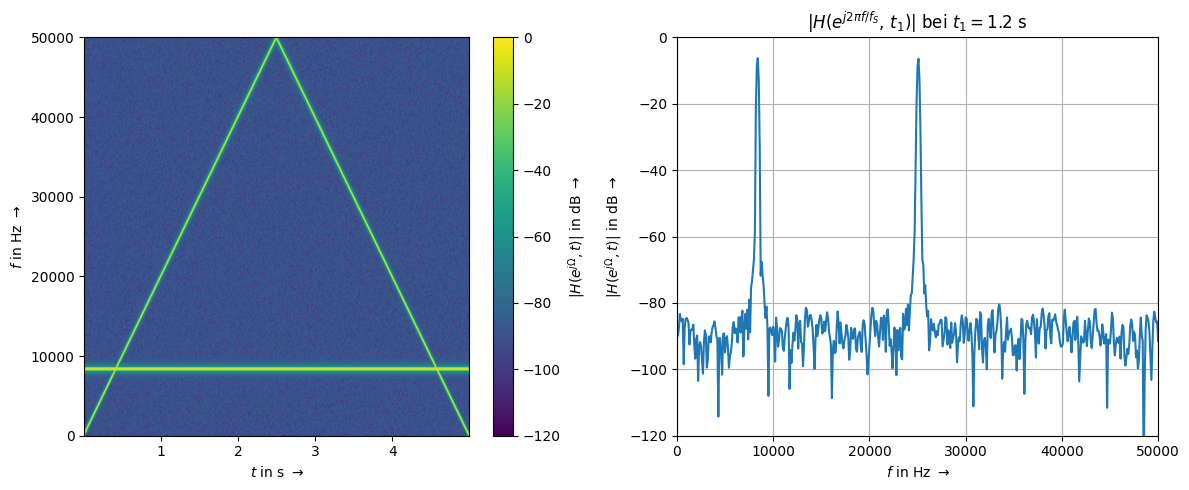

In [9]:
fig2, (ax21, ax22) = plt.subplots(**figsize, ncols=2, nrows=1);
# scale = NFFT * CGain # scale factor for correct *signal power* of spectrogram:
ax21.set_xlabel(t_label)
ax21.set_ylabel(f_label)
ax21.set_xlim([0,tmax])
ax21.set_ylim([0,fs/2])
Pxx, freqs, bins, im = ax21.specgram(x, NFFT=NFFT, Fs=fs, cmap='viridis',
                            noverlap=NFFT//2, mode = 'magnitude', window = win, 
                            scale = 'dB', vmin = dbmin, vmax = dbmax)
# freqs: DFT frequencies, bins: time steps           
fig2.colorbar(im, label = H_label, ax=ax21)
ax22.grid(True)
time_slot = int(len(bins)/4)
ax22.plot(freqs, 20*log10(Pxx[:,time_slot]))
ax22.set_xlabel(f_label); ax22.set_ylabel(H_label)
ax22.set_title(r'$|H(e^{j 2 \pi f / f_S},\, t_1)|$ bei $t_1=%0.1f$ s' %(bins[time_slot]))
ax22.set_ylim([dbmin, dbmax]); ax22.set_xlim([0,fs/2])
fig2.set_tight_layout(True)

Plotte ein Wasserfall-Diagramm

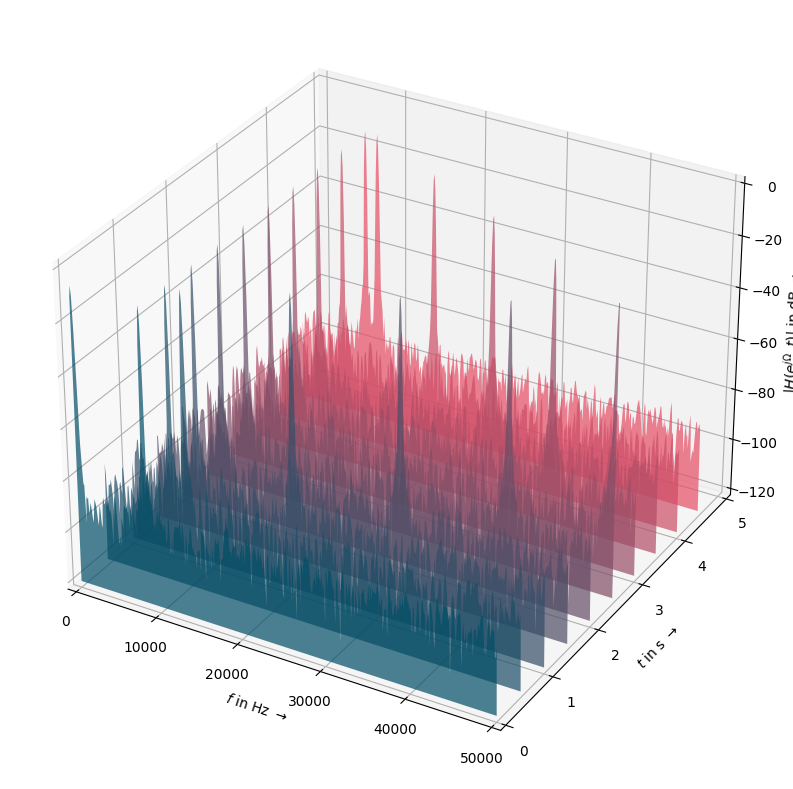

In [10]:
# creates static widget
%matplotlib inline 
 # creates interactive widget, ipympl needs to be installed
# %matplotlib widget
fig4, ax4 = plt.subplots(figsize=(11,8), subplot_kw = {'projection':'3d'})

xs = freqs # frequency axis
zs = arange(0,len(bins),100)  # time axis index
verts = []
mycolors = []

for z in zs:
    ys = np.maximum(20*log10(Pxx[:,z]),dbmin)
#    ys = np.random.rand(len(xs))
    ys[0], ys[-1] = dbmin, dbmin # set lower polygon points
    verts.append(list(zip(xs, ys)))
    mycolors.append((z/len(bins),0.3,0.4)) # r,g,b

poly = PolyCollection(verts, facecolors = mycolors)
                                      
poly.set_alpha(0.7) # set transparency
ax4.add_collection3d(poly, zs = zs/len(bins)*tmax, zdir='y')

ax4.set_xlabel(f_label); ax4.set_ylabel(t_label); ax4.set_zlabel(H_label)
ax4.set_xlim3d(0, max(xs)) # frequency
ax4.set_ylim3d(0, tmax) # time
ax4.set_zlim3d(dbmin, dbmax)
ax4.azim = -60# azimuth, default -60 deg.
ax4.elev = 30 # Höhe, default 30
# ax4.dist = 10 # Entfernung, default 10
fig4.set_tight_layout(True)

***
### Copyright

(c) 2016 - 2021 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2021*.